In [ ]:
# Import the packages required for my analysis
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn.svm as svm

In [ ]:
# Create dictionary with year as key and hospital visit dataframe as value (read each year from file)
years = list(map(str,list(range(2002,2023))))
yearDict = {}
for y in years:
    filePath = 'healthData/ed' + y + '-spss.sav'
    yearDict[y] = pd.read_spss(filePath)

## EDA

In [ ]:
# Check the dataframe shape for each year- notice the different field counts
for y in yearDict.keys():
    print(y, " Shape: ", yearDict[y].shape)

2002  Shape:  (37337, 260)
2003  Shape:  (40253, 255)
2004  Shape:  (36589, 255)
2005  Shape:  (33605, 279)
2006  Shape:  (33605, 359)
2007  Shape:  (35490, 395)
2008  Shape:  (34134, 395)
2009  Shape:  (34942, 404)
2010  Shape:  (34936, 426)
2011  Shape:  (31084, 431)
2012  Shape:  (29453, 598)
2013  Shape:  (24777, 591)
2014  Shape:  (23844, 1012)
2015  Shape:  (21061, 1031)
2016  Shape:  (19467, 949)
2017  Shape:  (16709, 949)
2018  Shape:  (20291, 945)
2019  Shape:  (19481, 911)
2020  Shape:  (14860, 912)
2021  Shape:  (16207, 912)
2022  Shape:  (16025, 913)


In [ ]:
# Print the number of fields present in all years, adding and checking one year at a time
# Working backwards chronologically, we see that 2002-2005 have no overlapping fields with the rest of the data
# Then we drop these 4 years
varNames = yearDict['2022'].columns
for y in reversed(list(yearDict.keys())):
    varNames = [x for x in varNames if x in yearDict[y].columns]
    print(len(varNames))

annualData = {}
for y in years[4:]:
    annualData[y] = yearDict[y]

913
911
911
911
905
900
900
897
892
460
454
336
336
331
311
310
280
0
0
0
0


In [ ]:
# Filter the dataset to only include the fields common across all years from 2006 onward
varNames = annualData['2022'].columns
for y in reversed(list(annualData.keys())):
    varNames = [x for x in varNames if x in yearDict[y].columns]



In [7]:
# Remove na Region values and check number of observations per year
for y in annualData.keys():
    print(y, " with region: ")
    print(
        annualData[y]
        [varNames]
        .dropna(subset=["REGION"])
        .shape
    )

2006  with region: 
(0, 280)
2007  with region: 
(35490, 280)
2008  with region: 
(34134, 280)
2009  with region: 
(34942, 280)
2010  with region: 
(34936, 280)
2011  with region: 
(31084, 280)
2012  with region: 
(29453, 280)
2013  with region: 
(24777, 280)
2014  with region: 
(23844, 280)
2015  with region: 
(21061, 280)
2016  with region: 
(19467, 280)
2017  with region: 
(16709, 280)
2018  with region: 
(20291, 280)
2019  with region: 
(19481, 280)
2020  with region: 
(14860, 280)
2021  with region: 
(16207, 280)
2022  with region: 
(16025, 280)


In [8]:
# We find that 2006 has no values for the Region variable despite its existence so it can't be used for our Albuquerque analysis
del annualData['2006']

# Create a sample dataset of the available fields
availableFields = (
    annualData['2007']
    [varNames]
    .head(100)
)

In [ ]:
# Load our fire estimates from part 1
with open('IntData/fire_strength_by_year.json') as f:
    fireStrengths = json.load(f)


In [ ]:
# Identify the diagnosis/symptom codes that match respiratory health issues
respCodes = ["Respiratory", "respiratory", "nasal", "Nasal", "Strep", "congestion", "breath",
             "Breath", "Wheez", "Sinus", "sinus", "Cough", "cough", "throat", "bronch", "Bronch",
             "Asthma", "asthma" "COPD", "lung", "pneumonia"]

# Create the dictionary of annual respiratory health scores, then calculate scores
# Weighted sum of respiratory related visits, with more emphasis on the primary symptom/diagnosis of each visit
respScores = {}
for y in annualData.keys():
    annualRespScore = 0
    for i in [1,2,3]:
        colnames = ['DIAG'+str(i),'RFV'+str(i)]
        diags = [x for x in annualData[y][colnames[0]] if any(c in x for c in respCodes)]
        rfvs = [x for x in annualData[y][colnames[1]] if any(c in str(x) for c in respCodes)]
        colFactor = [3/2,1,1/2]
        annualRespScore = annualRespScore + colFactor[i-1]*(len(diags) + len(rfvs))
    respScores[y]=annualRespScore


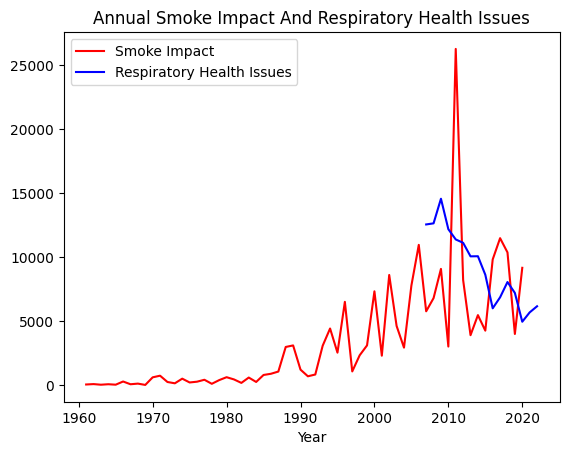

In [11]:
# Get chronological strengths and AQIs, then plot timeseries
years = range(1961,2021)
healthYears = [int(a) for a in list(annualData.keys())]

chrono_fire = []
for year in years:
    chrono_fire.append(fireStrengths[str(year)])
chrono_health = []
for y in healthYears:
    chrono_health.append(respScores[str(y)])
plt.plot(years,chrono_fire,color='red', label = "Smoke Impact")
plt.plot(healthYears,chrono_health,color='blue', label = "Respiratory Health Issues")
plt.title("Annual Smoke Impact And Respiratory Health Issues")
plt.xlabel("Year")
plt.legend();

In [ ]:
# Create a list of fire estimates for the years for which we have our health estimate
fires = []
for year in healthYears:
    fires.append(fireStrengths[str(year)])

# Create an annual dataframe to compare fire and health scores
annualFireHealth = pd.DataFrame()
annualFireHealth['year'] = healthYears
annualFireHealth['fire'] = [int(x) for x in fires]
annualFireHealth['health'] = [int(x) for x in chrono_health]

print(annualFireHealth)

    year   fire  health
0   2007   5778   12566
1   2008   6808   12653
2   2009   9094   14576
3   2010   3023   12195
4   2011  26285   11394
5   2012   8222   11131
6   2013   3911   10073
7   2014   5480   10082
8   2015   4266    8634
9   2016   9831    6011
10  2017  11494    6871
11  2018  10380    8067
12  2019   4006    7215
13  2020   9177    4963
14  2021   8619    5692
15  2022   9176    6171


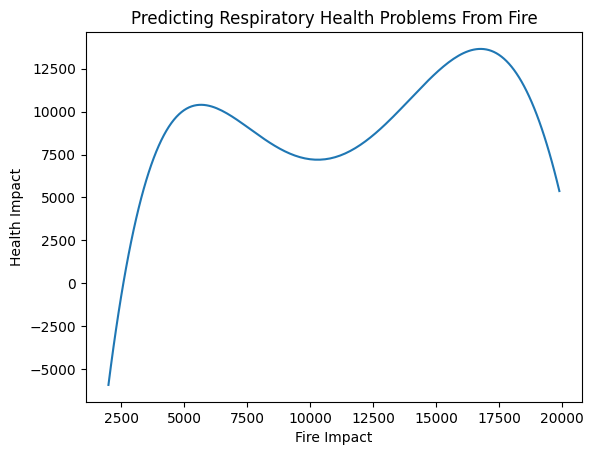

In [ ]:
# Create list of fires for years with health data
# Design model to predict respiratory health from fire strength
# Plot the relationship between fire estimate and predicted health score
testFire = []
for year in healthYears:
    testFire.append((fireStrengths[str(year-1)]+2*fireStrengths[str(year)])/3)

testMod = np.poly1d(np.polyfit(testFire,chrono_health,5))
x2 = np.arange(2000,20000,100)
plt.plot(x2, testMod(x2))
plt.title("Predicted Respiratory Health vs. Fire Estimate")
plt.xlabel("Fire Impact")
plt.ylabel("Health Impact");

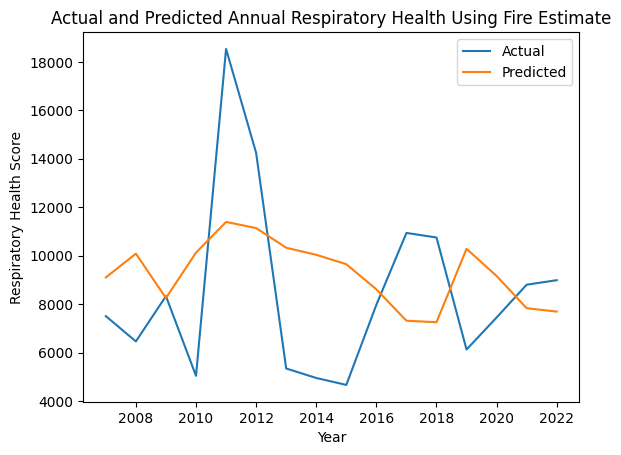

In [ ]:
# Using the above model, predict and plot respiratory health to compare to actual values

plt.plot(healthYears,testFire,label="Actual")
plt.plot(healthYears,testMod(testFire),label="Predicted")
plt.legend()
plt.title("Actual and Predicted Annual Respiratory Health Using Fire Estimate")
plt.xlabel("Year")
plt.ylabel("Respiratory Health Score")
plt.show();

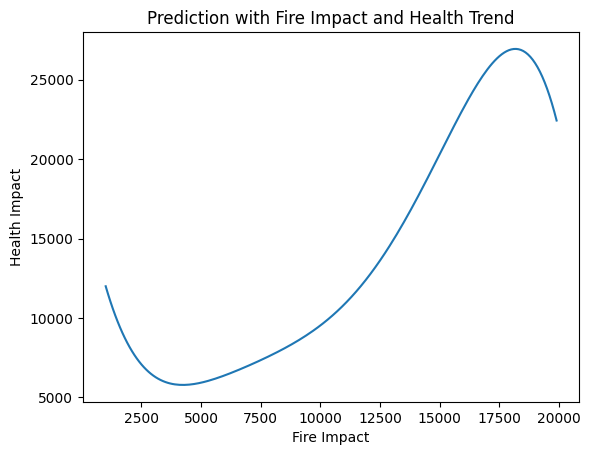

In [ ]:
# Determine the average fire estimate and calculate model inputs using
# last year's health and this year's standardized fire estimate
avgFire = sum(fires)/len(fires)
inputVals = []
for year in healthYears[1:]:
    prevHealth = respScores[str(year-1)]
    curFire = fireStrengths[str(year)]
    inputVals.append(prevHealth + 1/2*(curFire-avgFire))

# Design model using combined field (above) to predict respiratory health score
healthVals = chrono_health[1:]
comboMod = np.poly1d(np.polyfit(inputVals,healthVals,5))

# Plot the relationship between fire estimate and predicted health score using our new model
x = np.arange(1000,20000,100)
plt.plot(x,comboMod(x))
plt.title("Prediction with Fire Impact and Health Trend")
plt.xlabel("Fire Impact")
plt.ylabel("Health Impact")
plt.show();

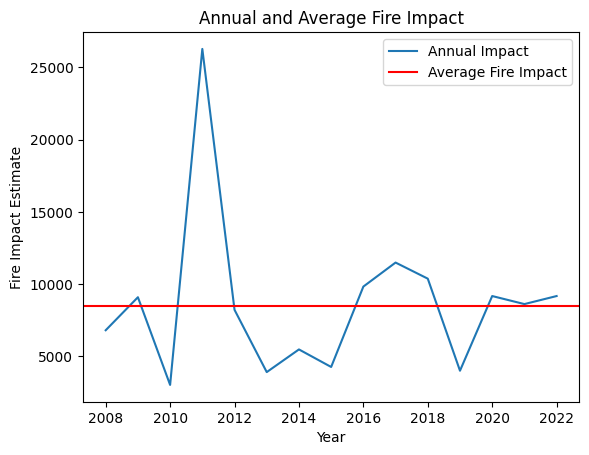

In [ ]:
# Plot the annual fire estimate with average value shown for context on standardization
yrs = healthYears[1:]
f = []
for yr in yrs:
    f.append(fireStrengths[str(yr)])

plt.plot(yrs,f,label="Annual Impact")
plt.axhline(y=avgFire,color="Red",label="Average Fire Impact")
plt.xlabel("Year")
plt.ylabel("Fire Impact Estimate")
plt.title("Annual and Average Fire Impact")
plt.legend()
plt.show();

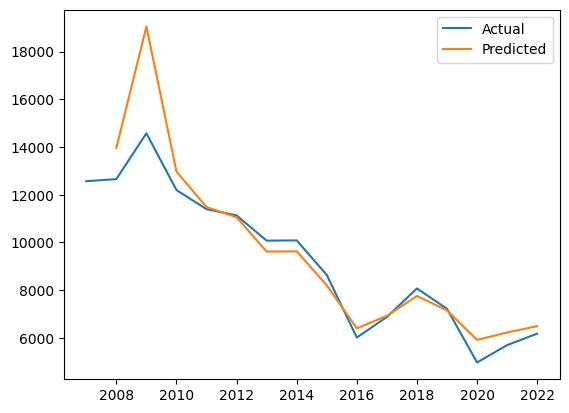

In [ ]:
# Plot predicted health scores using our combined input model
# Plot actual health scores to compare

plt.plot(healthYears,annualFireHealth['health'],label="Actual")
plt.plot(healthYears[1:],comboMod(healthVals),label="Predicted")
plt.legend()
plt.title("Actual and Predicted Annual Respiratory Health Using Fire and Past Health")
plt.xlabel("Year")
plt.ylabel("Respiratory Health Score")
plt.show();